# Bayesian Model Averaging Using the BIC

## Poisson Model Example
- First we evaluate a standalone Poisson example with a Gamma-distributed Lambda parameter.

Poisson BIC: 4048.59


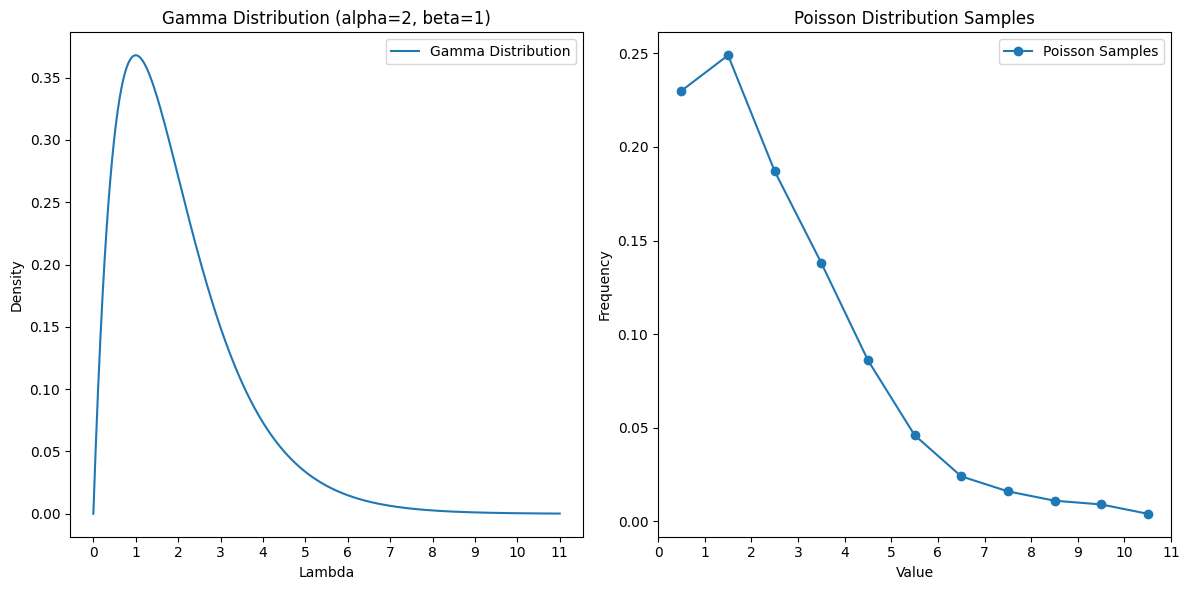

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, poisson

# Parameters for the Gamma distribution
alpha = 2
beta = 1

# Define the Gamma distribution
gamma_dist = gamma(a=alpha, scale=1/beta)

# Sample lambda from the Gamma distribution
np.random.seed(20240808)
lambda_samples = gamma_dist.rvs(size=1000)

# Generate Poisson-distributed data using the sampled lambda values
poisson_samples = [poisson.rvs(mu=lmbda) for lmbda in lambda_samples]

# Calculate the mean of the lambda samples to use as the Poisson parameter
lambda_mean = np.mean(lambda_samples)

# Calculate the log-likelihood of the observed data
log_likelihood_bma = np.sum(poisson.logpmf(poisson_samples, mu=lambda_mean))

# Number of parameters (k) in the Poisson model (only lambda)
k = 1

# Number of data points (n)
n = len(poisson_samples)

# Calculate BIC
bic = k * np.log(n) - 2 * log_likelihood_bma

print(f"Poisson BIC: {round(bic,2)}")

# Plot the Gamma distribution
x_bins = range(0, max(poisson_samples) + 1)

x = np.linspace(0, max(x_bins), 1000)
gamma_pdf = gamma_dist.pdf(x)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(x, gamma_pdf, label='Gamma Distribution')
plt.title('Gamma Distribution (alpha=2, beta=1)')
plt.xlabel('Lambda')
plt.xticks(x_bins)
plt.ylabel('Density')
plt.legend()

# Plot the histogram of Poisson samples

# Calculate histogram data
hist, bin_edges = np.histogram(poisson_samples, bins=x_bins, density=True)

bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
plt.subplot(1, 2, 2)
plt.plot(bin_centers, hist, 'o-', label='Poisson Samples')
plt.title('Poisson Distribution Samples')
plt.xlabel('Value')
plt.xticks(x_bins)
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

## Fitting a Uniform Distribution

In [2]:
import numpy as np
from scipy.optimize import minimize

# Data
y = [2, 3, 7, 8, 4, 5, 10, 15, 8, 6, 3, 11]

# Calculate the mean of the data (MLE for lambda in Poisson distribution)
mean_y = np.mean(y)
variance_y = np.var(y)

# Define the Uniform distribution PMF
def uniform_pmf(k, n):
    k = np.asarray(k)  # Ensure k is a numpy array
    return [1 / n if j <= n else 0 for j in k]

# Define the negative log-likelihood function for the Uniform distribution
def neg_log_likelihood_uniform(params, data):
    n = params[0]  # Assuming n is the number of trials in the data
    pmf_values = uniform_pmf(data, n)
    # Avoid log(0) by replacing 0 with a very small number
    pmf_values = np.where(np.array(pmf_values) == 0, 1e-10, pmf_values)
    return -np.sum(np.log(pmf_values))

# Initial guesses for upper bound
initial_params = [max(y)]

# Fit the Uniform distribution to the data
model_uniform = minimize(neg_log_likelihood_uniform, initial_params, args=(y,), bounds=[(1, None)])

# Extract the fitted parameter
n_fitted = model_uniform.x[0]

# Print the fitted parameter
print(f"Fitted n (maximal value): {n_fitted}")

# Calculate the log-likelihood of the model
log_likelihood_uniform = -neg_log_likelihood_uniform([n_fitted], y)

# Number of parameters (k) and number of data points (n)
k = 1
n = len(y)

# Calculate BIC
bic_uniform = k * np.log(n) - 2 * log_likelihood_uniform

print(f"BIC for the Uniform model: {int(bic_uniform)}")

Fitted n (maximal value): 15.0
BIC for the Uniform model: 67


## Fitting a Poisson Model

In [3]:
import numpy as np
from scipy.stats import poisson

# Calculate the log-likelihood of the Poisson model
log_likelihood_poi = np.sum(poisson.logpmf(y, mean_y))

# Number of parameters (k) and number of data points (n)
k = 1
n = len(y)

# Calculate the Bayesian Information Criterion (BIC)
bic_poi = k * np.log(n) - 2 * log_likelihood_poi

print(f"Fitted λ (mean): {round(mean_y, 1)}")
print(f"BIC for the Poisson model: {int(bic_poi)}")

Fitted λ (mean): 6.8
BIC for the Poisson model: 69


## Fitting a Binomial Model

In [4]:
import numpy as np
from scipy.stats import binom
from scipy.optimize import minimize

# Number of trials (n) - assuming the maximum value in y as the number of trials
n_trials_binom = np.max(y)

# Define the negative log-likelihood function for the Binomial model
def neg_log_likelihood(params, y, n_trials):
    p = params[0]
    if p < 0 or p > 1 or n_trials < 1:
        return np.inf  # Return a large number to penalize invalid parameters
    result = -np.sum(binom.logpmf(y, n_trials, p))
    return result

# Initial guess for p
initial_guess = np.array([0.5])

n_trials_range = range(np.max(y),np.max(y)*10)


best_p = None
best_n_trials = None
best_neg_log_likelihood = np.inf

for n_trials_binom in n_trials_range:
    # Minimize the negative log-likelihood
    result = minimize(neg_log_likelihood, initial_guess, args=(y, n_trials_binom), bounds=[(0, 1)])
    if result.fun < best_neg_log_likelihood:
        best_neg_log_likelihood = result.fun
        best_p = result.x[0]
        best_n_trials = n_trials_binom

p_fitted_binom = best_p
n_fitted_binom = best_n_trials

# Calculate the log-likelihood
log_likelihood_binom = -best_neg_log_likelihood

# Number of parameters (k)
k = 2

# Number of data points (n)
n = len(y)

# Calculate BIC
bic_binom = k * np.log(n) - 2 * log_likelihood_binom

print(f"Fitted p (probability): {round(p_fitted_binom, 1)}")
print(f"Fitted n (number of trials): {n_fitted_binom}")
print("BIC for the Binomial model:", int(bic_binom))

Fitted p (probability): 0.5
Fitted n (number of trials): 16
BIC for the Binomial model: 89


## Fitting a Negative Binomial

In [5]:
import numpy as np
from scipy.stats import nbinom
from scipy.optimize import minimize

# Define the negative log-likelihood function for the Negative Binomial distribution
def neg_log_likelihood_nb(params, data):
    r, p = params
    return -np.sum(nbinom.logpmf(y, r, p))

# Initial guesses for r and p
initial_params = [1, 0.5]

# Fit the Negative Binomial distribution to the data
model_nb = minimize(neg_log_likelihood_nb, initial_params, args=(y,), bounds=[(1e-5, None), (1e-5, 1-1e-5)])

# Extract the fitted parameters
r_nb_fitted, p_nb_fitted = model_nb.x

# Print the fitted parameters
print(f"Fitted r (number of claims until stop): {round(r_nb_fitted,1)}")
print(f"Fitted p (probability of a claim): {round(p_nb_fitted,1)}")

# Calculate the log-likelihood of the model
log_likelihood_nb = -neg_log_likelihood_nb((r_nb_fitted, p_nb_fitted), y)

# Number of parameters (k) and number of data points (n)
k = 2
n = len(y)

# Calculate BIC
bic_nb = k * np.log(n) - 2 * log_likelihood_nb

print("BIC for the Negative Binomial model:", int(bic_nb))

Fitted r (number of claims until stop): 7.1
Fitted p (probability of a claim): 0.5
BIC for the Negative Binomial model: 68


## Fitting a Beta-Binomial

In [6]:
import numpy as np
from scipy.special import betaln, comb
from scipy.optimize import minimize

# Define the Beta-Binomial PMF
def beta_binomial_pmf(k, n, alpha, beta):
    k = np.asarray(k)  # Ensure k is a numpy array
    binom_coeff = comb(n, k)  # Calculate the binomial coefficient
    pmf = binom_coeff * np.exp(betaln(k + alpha, n - k + beta) - betaln(alpha, beta))
    return pmf

# Define the negative log-likelihood function for the Beta-Binomial distribution
def neg_log_likelihood_bb(params, data):
    alpha, beta = params
    n = max(data)  # Assuming n is the maximal value in the data
    return -np.sum(np.log(beta_binomial_pmf(data, n, alpha, beta)))

# Initial guesses for alpha and beta
initial_params = [1, 1]

# Fit the Beta-Binomial distribution to the data
model_bb = minimize(neg_log_likelihood_bb, initial_params, args=(y,), bounds=[(1e-5, None), (1e-5, None)])

# Extract the fitted parameters
alpha_bb_fitted, beta_bb_fitted = model_bb.x

# Print the fitted parameters
print(f"Fitted α (expected number of successes): {round(alpha_bb_fitted,1)}")
print(f"Fitted β (expected number of failures): {round(beta_bb_fitted,1)}")

# Calculate the log-likelihood of the model
log_likelihood_bb = -neg_log_likelihood_bb((alpha_bb_fitted, beta_bb_fitted), y)

# Number of parameters (k) and number of data points (n)
k = 2
n = max(y)

# Calculate BIC
bic_bb = k * np.log(n) - 2 * log_likelihood_bb

print("BIC for the Beta-Binomial model:", int(bic_bb))

Fitted α (expected number of successes): 1.9
Fitted β (expected number of failures): 2.2
BIC for the Beta-Binomial model: 70


## Model Averaging Using the Bayesian Information Criterion (BIC)

In [10]:
# Calculate the weights for each model based on their BIC values
bic_values = np.array([bic_uniform, bic_poi, bic_binom, bic_nb, bic_bb])
min_bic = np.min(bic_values)
delta_bic = bic_values - min_bic
weights = np.exp(-0.5 * delta_bic) / np.sum(np.exp(-0.5 * delta_bic))

# Print the weights for each model
print("Weights:")
print(f" - Uniform = {int(round(weights[0], 2)*100)}%")
print(f" - Poisson = {int(round(weights[1], 2)*100)}%")
print(f" - Binomial = {int(round(weights[2], 2)*100)}%")
print(f" - Negative Binomial = {int(round(weights[3], 2)*100)}%")
print(f" - Beta-Binomial = {int(round(weights[4], 2)*100)}%")

# Calculate the weighted average of the models
x = np.arange(0, max(y) + 1)

# Uniform PMF
uniform_pmf_values = uniform_pmf(x, n_fitted)
uniform_pmf_values = np.array(uniform_pmf_values)  # Convert to NumPy array before multiplication

# Poisson PMF
poisson_pmf = poisson.pmf(x, mean_y)

# Binomial PMF
binomial_pmf = binom.pmf(x, n_trials_binom, p_fitted_binom)

# Negative Binomial PMF
nbinom_pmf = nbinom.pmf(x, r_nb_fitted, p_nb_fitted)

# Beta-Binomial PMF
beta_binom_pmf = beta_binomial_pmf(x, max(y), alpha_bb_fitted, beta_bb_fitted)

# Weighted average PMF
average_pmf = (weights[0] * uniform_pmf_values +
               weights[1] * poisson_pmf +
               weights[2] * binomial_pmf +
               weights[3] * nbinom_pmf +
               weights[4] * beta_binom_pmf)

# Calculate the log-likelihood of the averaged model
log_likelihood_bma = np.sum(np.log(average_pmf[y]))

# Number of parameters for each model
num_parameters_uniform = 1  # Uniform
num_parameters_poi = 1  # Poisson
num_parameters_binom = 2  # Binomial
num_parameters_nb = 2   # Negative Binomial
num_parameters_bb = 2   # Beta-Binomial

# Calculate the weighted average of the number of parameters
num_parameters = (weights[0] * num_parameters_uniform +
                  weights[1] * num_parameters_poi +
                  weights[2] * num_parameters_binom +
                  weights[3] * num_parameters_nb +
                  weights[4] * num_parameters_bb)

print(f"Number of parameters in the averaged model: {round(num_parameters,1)}")

# Number of data points
n = len(y)

# Calculate BIC
bic_averaged_model = num_parameters * np.log(n) - 2 * log_likelihood_bma

print(f"BIC of the averaged model: {int(bic_averaged_model)}")

Weights:
 - Uniform = 44%
 - Poisson = 17%
 - Binomial = 0%
 - Negative Binomial = 27%
 - Beta-Binomial = 12%
Number of parameters in the averaged model: 1.4
BIC of the averaged model: 66


## Visualizing the Different Models

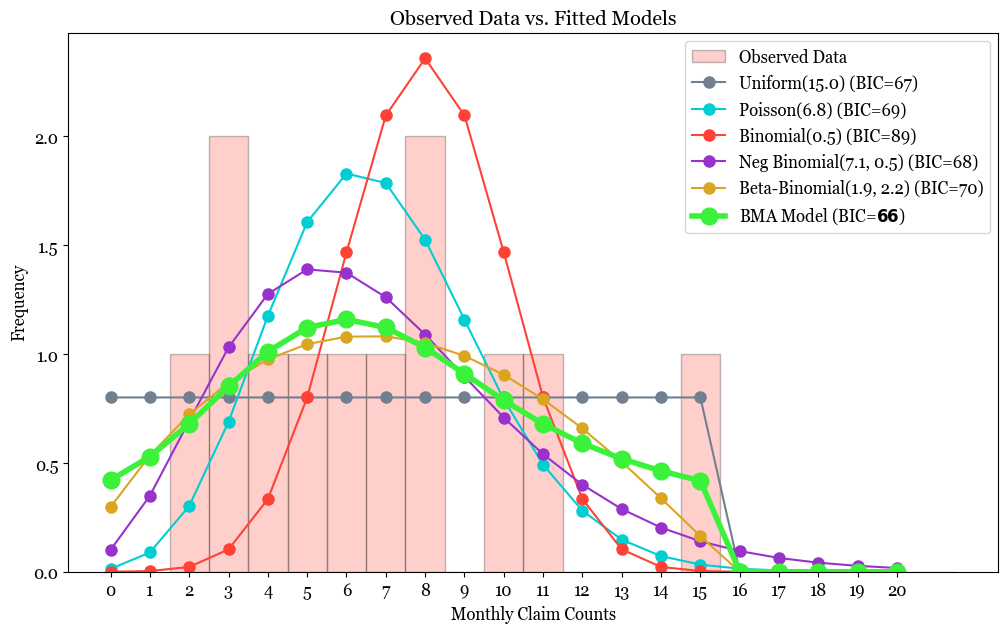

In [8]:
# Set the font properties
plt.rcParams['font.family'] = 'Georgia'
plt.rcParams['font.size'] = 12

# Plot the observed data as a histogram
plt.figure(figsize=(12, 7))
plt.hist(y, bins=np.arange(min(y)-0.5, 21 + 1.5), alpha=0.25, color='#FF4136', edgecolor='black', label='Observed Data')

x = np.arange(0, 21)

# Calculate the expected Uniform probabilities
uniform_pmf_values = uniform_pmf(x, n_fitted)
uniform_pmf_values = [x * len(y) for x in uniform_pmf_values]

# Overlay the fitted Uniform distribution
plt.plot(x, uniform_pmf_values, 'o-', label=f'Uniform({round(n_fitted,1)}) (BIC={int(bic_uniform)})', color='#708090', markersize=8)

# Overlay the fitted Poisson distribution
poisson_pmf = poisson.pmf(x, mean_y) * len(y)
plt.plot(x, poisson_pmf, 'o-', label=f'Poisson({round(mean_y,1)}) (BIC={int(bic_poi)})', color='#00CED1', markersize=8)

# Calculate the expected Binomial probabilities
binom_pmf = binom.pmf(x, n_fitted_binom, p_fitted_binom) * len(y)

# Overlay the fitted Binomial distribution
plt.plot(x, binom_pmf, 'o-', label=f'Binomial({round(p_fitted_binom, 1)}) (BIC={int(bic_binom)})', color='#FF4136', markersize=8)

# Calculate the expected Negative Binomial probabilities
nbinom_pmf = nbinom.pmf(x, r_nb_fitted, p_nb_fitted) * len(y)

# Overlay the fitted Negative Binomial distribution
plt.plot(x, nbinom_pmf, 'o-', label=f'Neg Binomial({round(r_nb_fitted,1)}, {round(p_nb_fitted,1)}) (BIC={int(bic_nb)})', color='#9932CC', markersize=8)

# Calculate the expected Beta-Binomial probabilities
beta_binom_pmf = beta_binomial_pmf(x, max(y), alpha_bb_fitted, beta_bb_fitted) * len(y)

# Overlay the fitted Beta-Binomial distribution
plt.plot(x, beta_binom_pmf, 'o-', label=f'Beta-Binomial({round(alpha_bb_fitted,1)}, {round(beta_bb_fitted,1)}) (BIC={int(bic_bb)})', color='#DAA520', markersize=8)

# Overlay the weighted average model (unhighlighted color is #32CD32)
plt.plot(x, np.pad(average_pmf, (0, 5), 'constant') * len(y), 'o-', label=f'BMA Model (BIC=$\\mathbf{{{int(bic_averaged_model)}}}$)', color='#3BF23B', markersize=12, linewidth=4)

# Set x-axis labels for every element
plt.xticks(np.arange(0, 21))

plt.title('Observed Data vs. Fitted Models')
plt.xlabel('Monthly Claim Counts')
plt.ylabel('Frequency')
plt.legend()
plt.show()